In [ ]:
!pip install "git+https://github.com/facebookresearch/segment-anything-2.git" tqdm
from sam2.sam2_image_predictor import SAM2ImagePredictor

  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-0p_1kmzg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-0p_1kmzg
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.4 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=501909 sha256=da3f0fef0571ce56721073ab8e747d14a0a4d37232b494533d3aca50d4c1cd54
  Stored in directory: /tmp/pip-ephem-wheel-cache-0c8fpl2q/wheels/b0/5b/a1/c16dafb8c3c0046f1158e7fa7570559a72085df5beab759ba0
  Created wheel

# 환경 설정, 라이브러리 설치

In [ ]:
print("=" * 60)
print("환경 설정 및 라이브러리 설치")
print("=" * 60)

!pip install ultralytics pycocotools tqdm

import os, glob, json, shutil, random, zipfile
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import jaccard_score

print("✅ 라이브러리 설치 완료")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

환경 설정 및 라이브러리 설치
✅ 라이브러리 설치 완료
PyTorch 버전: 2.8.0+cu126
CUDA 사용 가능: True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 경로 설정

In [ ]:
yaml_base = # ←YAML 경로
dataset_root = # ←데이터셋 루트
test_images_folder = f'{dataset_root}images/test'
test_labels_folder = f'{dataset_root}labels/test'
test_images = glob.glob(os.path.join(test_images_folder, '*.jpg'))

In [ ]:
# 클래스 정의
class_name_to_number = {
    'ConcreteCrack': '0',
    'Spalling': '1',
    'Efflorescene': '2',
    'Leak': '3',
    'Exposure': '4',
    'AspaltCrack': '5',
    'Pothole': '6',
    'SteelDamage': '7'
}
id_to_class_name = {v: k for k, v in class_name_to_number.items()}

# 학습 설정

In [ ]:
# SAM2 모델(속도/정확도에 따라 교체 가능)
sam2_model_name = "facebook/sam2-hiera-tiny"

In [ ]:
print("\n" + "=" * 60)
print("학습 설정")
print("=" * 60)

from argparse import Namespace
args = Namespace(
    epoch=150,
    project="yolo11n+sam2",
    name="experiment",
    config=yaml_base,
    cuda="0",
    resume=False,
    resume_path=""
)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda
os.environ["WANDB_MODE"] = "disabled"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ 디바이스: {device}")
print(f"✅ Epochs: {args.epoch}")
print(f"✅ 프로젝트: {args.project}/{args.name}")


학습 설정
✅ 디바이스: cuda
✅ Epochs: 150
✅ 프로젝트: yolo11n+sam2/experiment


# 8. YOLO11 모델 학습

In [ ]:
# T4 기준, 15분 내외로 학습 소요
print("\n" + "=" * 60)
print("8️⃣ YOLO11 모델 학습")
print("=" * 60)

########################################
# 사용 모델 설정
MODEL = "yolo11n.pt"
########################################

if args.resume and os.path.exists(args.resume_path):
    print(f"🔄 체크포인트 재개: {args.resume_path}")
    model = YOLO(args.resume_path)
else:
    print(f"🆕 새 모델 로드: {MODEL}")
    model = YOLO(MODEL)

model.to(device)

print(f"\n🚀 학습 시작...")
results = model.train(
    project=args.project,
    name=args.name,
    data=args.config,
    epochs=args.epoch,
    imgsz=512,
    batch=64,
    device=device,
    optimizer="auto",
    val=True,
    resume=args.resume,
    verbose=True,
    patience=100,
    save=True,
    plots=True,
)
print(f"\n✅ 학습 완료!")
print(f"📁 결과: {args.project}/{args.name}/")



8️⃣ YOLO11 모델 학습
🆕 새 모델 로드: yolo11n.pt

🚀 학습 시작...
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=experiment4, nbs=64, nms=False

# 9. 최적 모델 검증

In [ ]:
print("\n" + "=" * 60)
print("9️⃣ 최적 모델 검증")
print("=" * 60)

best_model_path = f"{args.project}/{args.name}4/weights/best.pt"
if os.path.exists(best_model_path):
    print(f"📦 최적 모델 로드: {best_model_path}")
    best_model = YOLO(best_model_path)

    print("\n📊 검증 세트 평가...")
    val_results = best_model.val(
        data=args.config,
        split='val',
        imgsz=512,
        batch=64,
        device=device,
    )
    print("\n✅ 검증 완료!")
    # detection-only 가중치인 경우 seg 속성이 없을 수 있으므로 안전하게 출력
    box_map50 = getattr(val_results.box, "map50", None)
    box_map = getattr(val_results.box, "map", None)
    seg_map50 = getattr(getattr(val_results, "seg", None), "map50", None)
    seg_map = getattr(getattr(val_results, "seg", None), "map", None)

    if box_map50 is not None: print(f"   - Box mAP50:     {box_map50:.4f}")
    if box_map  is not None:  print(f"   - Box mAP50-95:  {box_map:.4f}")
    if seg_map50 is not None: print(f"   - Mask mAP50:    {seg_map50:.4f}")
    if seg_map is not None:   print(f"   - Mask mAP50-95: {seg_map:.4f}")
else:
    raise FileNotFoundError(f"최적 모델 없음: {best_model_path}")


9️⃣ 최적 모델 검증
📦 최적 모델 로드: yolo11n+sam2/experiment4/weights/best.pt

📊 검증 세트 평가...
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 66.7±29.2 MB/s, size: 116.0 KB)
val: Scanning /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/labels/val.cache... 897 images, 126 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 897/897 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 1.6it/s 9.7s
                   all        897       2276      0.536      0.497      0.509      0.328
         ConcreteCrack        116        355      0.449      0.131      0.185     0.0727
              Spalling         55         92      0.433        0.5      0.458       0.29
          Efflorescene        113        306      0.447      0.454        0.4      0.231

# 학습 결과 요약


1️⃣2️⃣ 학습 결과 요약


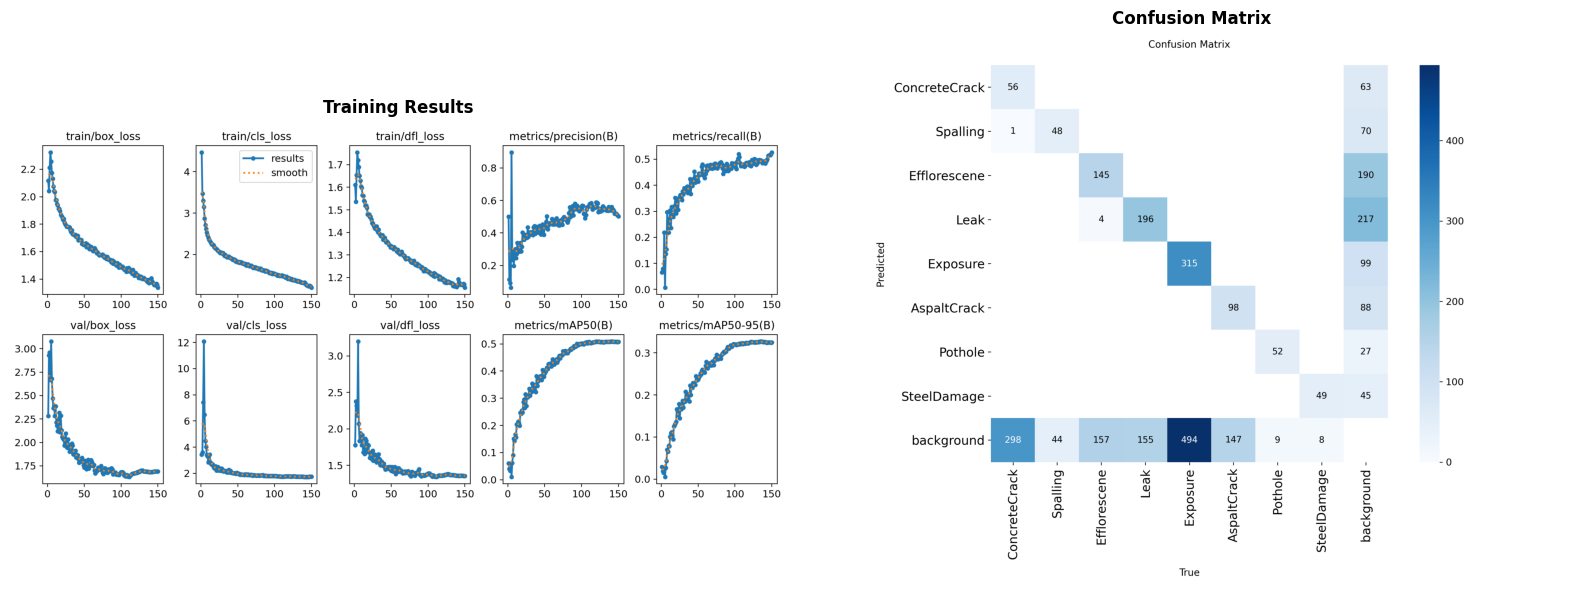

✅ 학습 요약: yolo11n+sam2/experiment4/training_summary.png


In [ ]:
print("\n" + "=" * 60)
print("1️⃣2️⃣ 학습 결과 요약")
print("=" * 60)
results_png = f"{args.project}/{args.name}4/results.png"
confusion_matrix_png = f"{args.project}/{args.name}4/confusion_matrix.png"
if os.path.exists(results_png) or os.path.exists(confusion_matrix_png):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if os.path.exists(results_png):
        img1 = Image.open(results_png); axes[0].imshow(img1)
        axes[0].set_title('Training Results', fontweight='bold'); axes[0].axis('off')
    if os.path.exists(confusion_matrix_png):
        img2 = Image.open(confusion_matrix_png); axes[1].imshow(img2)
        axes[1].set_title('Confusion Matrix', fontweight='bold'); axes[1].axis('off')
    plt.tight_layout()
    plt.savefig(f"{args.project}/{args.name}4/training_summary.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ 학습 요약: {args.project}/{args.name}4/training_summary.png")

# 테스트 세트 추론

In [ ]:
yolo_model = YOLO(best_model_path)

def run_yolo_sam2_inference(
    yolo_model,
    test_image_paths,
    dataset_root: str,
    output_folder: str,
    id_to_class_name: dict,
    sam2_model_name: str = "facebook/sam2-hiera-tiny",
    conf_threshold: float = 0.25,
    iou_threshold: float = 0.5,
    img_size: int = 512,
    device: str = "cuda"
):
    os.makedirs(output_folder, exist_ok=True)
    print("\n" + "=" * 60)
    print("🔟 YOLO + SAM2 테스트 세트 추론")
    print("=" * 60)
    print(f"🔍 테스트 이미지: {len(test_image_paths)}개")
    print(f"📁 결과 폴더: {output_folder}")

    # SAM2 로드 1회
    predictor = SAM2ImagePredictor.from_pretrained(sam2_model_name)
    predictor.model.to(device)
    predictor.model.eval()
    print(f"✅ SAM2 로드: {sam2_model_name}")

    ious = []
    ious_per_class = {v: [] for v in id_to_class_name.values()}  # 🔹 클래스별 IoU 저장용
    total_boxes = 0
    processed = 0
    class_counts = {}

    amp_ctx = torch.amp.autocast(device_type='cuda') if device == "cuda" else nullcontext()
    from contextlib import nullcontext

    with torch.no_grad(), (amp_ctx if device=="cuda" else nullcontext()):
        for img_path in tqdm(test_image_paths, desc="추론"):
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]

            # YOLO detection
            yres = yolo_model.predict(
                source=img_rgb,
                imgsz=img_size,
                conf=conf_threshold,
                iou=iou_threshold,
                device=device,
                verbose=False,
                half=(device=="cuda")
            )[0]

            boxes = yres.boxes.xyxy.cpu().numpy() if yres.boxes is not None else np.empty((0,4))
            classes = yres.boxes.cls.cpu().numpy().astype(int) if yres.boxes is not None else np.array([])
            confidences = yres.boxes.conf.cpu().numpy() if yres.boxes is not None else np.array([])

            total_boxes += len(boxes)

            if len(boxes) == 0:
                # 검출 없으면 원본 저장
                cv2.imwrite(f"{output_folder}/{os.path.basename(img_path)}", img)
                processed += 1
                continue

            # 클래스 카운트
            for cls in classes:
                cname = id_to_class_name.get(str(cls), f"Class_{cls}")
                class_counts[cname] = class_counts.get(cname, 0) + 1

            # SAM2 segmentation
            predictor.set_image(img_rgb)
            # masks shape: (N, 1, H, W) -> predictor 버전에 따라 다를 수 있음
            masks, _, _ = predictor.predict(box=boxes, multimask_output=False)

            # GT 마스크 로드(있을 때만 IoU)
            txt_path = f"{dataset_root}/labels/test/{os.path.basename(img_path).replace('.jpg', '.txt')}"
            gt_masks = []
            if os.path.exists(txt_path):
                with open(txt_path, "r") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) > 3:
                            mask = np.zeros((h, w), dtype=np.uint8)
                            coords = np.array(list(map(float, parts[1:])))
                            xs = (coords[0::2] * w).astype(np.int32)
                            ys = (coords[1::2] * h).astype(np.int32)
                            polygon = np.stack([xs, ys], axis=-1)
                            cv2.fillPoly(mask, [polygon], 1)
                            gt_masks.append(mask)

            # 시각화
            overlay = img.copy()
            for box, mask, cls, conf in zip(boxes, masks, classes, confidences):
                sam_mask = mask[0].astype(np.uint8)  # (H, W)
                if sam_mask.shape != (h, w):
                    sam_mask = cv2.resize(sam_mask, (w, h), interpolation=cv2.INTER_NEAREST)

                # IoU
                if gt_masks:
                    best_iou = 0
                    best_class = id_to_class_name.get(str(cls), f"Class_{cls}")
                    if sam_mask.sum() > 0:
                        for g in gt_masks:
                            if g.sum() > 0:
                                iou = jaccard_score(g.flatten(), sam_mask.flatten(), zero_division=0)
                                best_iou = max(best_iou, iou)
                    if best_iou > 0:
                        ious.append(best_iou)
                        ious_per_class[best_class].append(best_iou)  # 🔹 클래스별 IoU 기록

                # 마스크 색상(클래스 고정)
                np.random.seed(int(cls))
                color = np.random.randint(50, 255, 3).tolist()
                overlay[sam_mask == 1] = color

            result = cv2.addWeighted(img, 0.6, overlay, 0.4, 0)

            # 박스/라벨
            for box, cls, conf in zip(boxes, classes, confidences):
                x1, y1, x2, y2 = box.astype(int)
                cname = id_to_class_name.get(str(cls), f'Class_{cls}')
                np.random.seed(int(cls))
                box_color = tuple(np.random.randint(50, 255, 3).tolist())
                cv2.rectangle(result, (x1, y1), (x2, y2), box_color, 2)
                label = f'{cname}: {conf:.2f}'
                (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(result, (x1, y1 - th - 10), (x1 + tw + 10, y1), box_color, -1)
                cv2.putText(result, label, (x1 + 5, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

            cv2.imwrite(f"{output_folder}/{os.path.basename(img_path)}", result)
            processed += 1

    # 통계/시각화 저장
    print("\n" + "=" * 60)
    print("📊 YOLO+SAM2 최종 결과")
    print("=" * 60)
    print(f"처리 이미지: {processed}/{len(test_image_paths)}개")
    print(f"검출 박스: {total_boxes}개")

    if ious:
        print(f"  IoU 평균: {np.mean(ious):.4f} | 중앙값: {np.median(ious):.4f} | 최소: {np.min(ious):.4f} | 최대: {np.max(ious):.4f} | N={len(ious)}")

        # 🔹 클래스별 평균 IoU 출력
        print("\n📈 클래스별 평균 IoU")
        for cname, vals in ious_per_class.items():
            if len(vals) > 0:
                print(f" - {cname:20s}: {np.mean(vals):.4f} (N={len(vals)})")
            else:
                print(f" - {cname:20s}: 데이터 없음")


        # IoU 히스토그램
        plt.figure(figsize=(7,5))
        plt.hist(ious, bins=20)
        plt.axvline(np.mean(ious), linestyle='--', linewidth=2, label=f'Mean {np.mean(ious):.3f}')
        plt.legend(); plt.title("IoU Distribution"); plt.xlabel("IoU"); plt.ylabel("Freq")
        plt.tight_layout(); plt.savefig(f"{output_folder}/iou_hist.png", dpi=150); plt.show()

    if class_counts:
        # 클래스 분포
        items = [(k, v) for k, v in class_counts.items() if v>0]
        if items:
            items.sort(key=lambda x: x[1], reverse=True)
            classes, counts = zip(*items)
            plt.figure(figsize=(10,4))
            plt.bar(classes, counts)
            plt.xticks(rotation=45, ha='right'); plt.title("Detections by Class")
            plt.tight_layout(); plt.savefig(f"{output_folder}/class_distribution.png", dpi=150); plt.show()

    # 요약 텍스트
    summary_text = [
        "="*60,
        "YOLO + SAM2 추론 결과 요약",
        "="*60,
        f"- 전체 테스트 이미지: {len(test_image_paths)}",
        f"- 처리된 이미지: {processed}",
        f"- 총 검출 박스: {total_boxes}",
    ]
    if class_counts:
        summary_text.append("\n[클래스별 검출 통계]")
        total = total_boxes if total_boxes>0 else 1
        for k,v in sorted(class_counts.items(), key=lambda x:x[1], reverse=True):
            summary_text.append(f"- {k:20s}: {v:4d}개 ({v/total*100:.1f}%)")

    if ious:
        summary_text += [
            "\n[IoU 평가]",
            f"- 평균: {np.mean(ious):.4f}",
            f"- 중앙값: {np.median(ious):.4f}",
            f"- 표준편차: {np.std(ious):.4f}",
            f"- 최소/최대: {np.min(ious):.4f} / {np.max(ious):.4f}",
            f"- N: {len(ious)}"
        ]

    summary_text += [
        "\n[모델 설정]",
        f"- SAM2 모델: {sam2_model_name}",
        f"- conf: {conf_threshold} | iou: {iou_threshold} | img_size: {img_size}",
        "\n[출력 경로]",
        f"- 결과 이미지: {output_folder}",
        "="*60
    ]
    summary_text = "\n".join(summary_text)
    print(summary_text)
    with open(f"{output_folder}/summary_report.txt",'w',encoding='utf-8') as f:
        f.write(summary_text)



🔟 YOLO + SAM2 테스트 세트 추론
🔍 테스트 이미지: 898개
📁 결과 폴더: /content/predictions_yolo11n_sam2_150_new
✅ SAM2 로드: facebook/sam2-hiera-tiny


추론: 100%|██████████| 898/898 [07:40<00:00,  1.95it/s]



📊 YOLO+SAM2 최종 결과
처리 이미지: 898/898개
검출 박스: 725개
  IoU 평균: 0.4597 | 중앙값: 0.4860 | 최소: 0.0002 | 최대: 0.9645 | N=355

📈 클래스별 평균 IoU
 - ConcreteCrack       : 0.2691 (N=98)
 - Spalling            : 0.6789 (N=16)
 - Efflorescene        : 0.7493 (N=13)
 - Leak                : 0.5356 (N=128)
 - Exposure            : 0.7416 (N=11)
 - AspaltCrack         : 0.3416 (N=55)
 - Pothole             : 0.5951 (N=26)
 - SteelDamage         : 0.6538 (N=8)


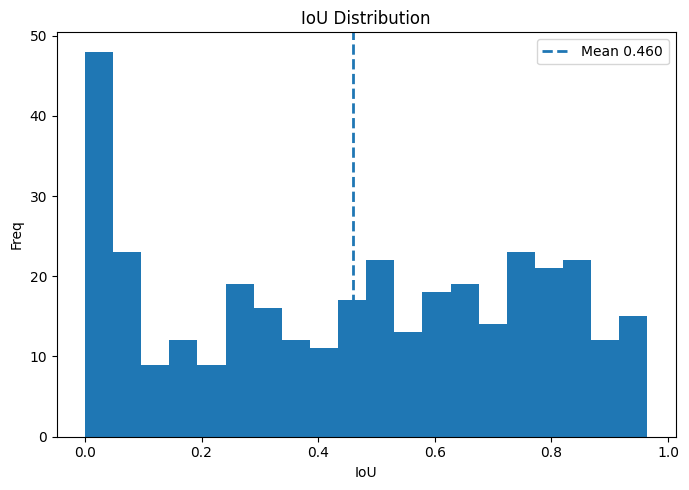

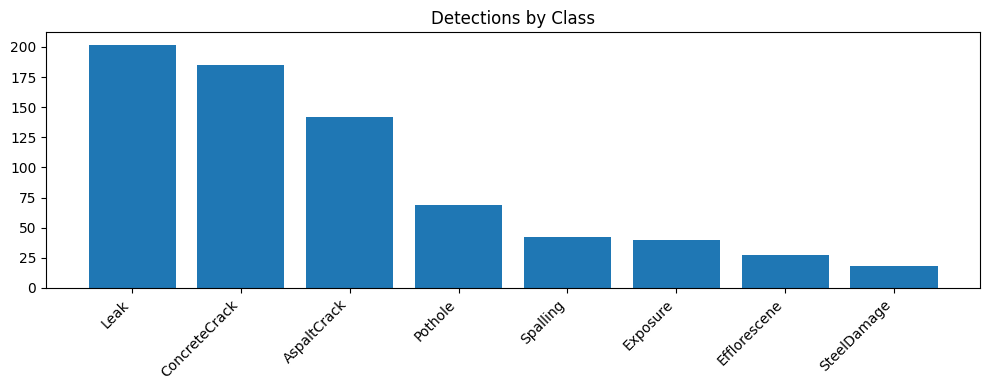

YOLO + SAM2 추론 결과 요약
- 전체 테스트 이미지: 898
- 처리된 이미지: 898
- 총 검출 박스: 725

[클래스별 검출 통계]
- Leak                :  202개 (27.9%)
- ConcreteCrack       :  185개 (25.5%)
- AspaltCrack         :  142개 (19.6%)
- Pothole             :   69개 (9.5%)
- Spalling            :   42개 (5.8%)
- Exposure            :   40개 (5.5%)
- Efflorescene        :   27개 (3.7%)
- SteelDamage         :   18개 (2.5%)

[IoU 평가]
- 평균: 0.4597
- 중앙값: 0.4860
- 표준편차: 0.3007
- 최소/최대: 0.0002 / 0.9645
- N: 355

[모델 설정]
- SAM2 모델: facebook/sam2-hiera-tiny
- conf: 0.25 | iou: 0.5 | img_size: 512

[출력 경로]
- 결과 이미지: /content/predictions_yolo11n_sam2_150_new

🎉 모든 작업 완료!

📂 주요 결과물:
   1. 데이터셋: /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets//
   2. 최적 모델: yolo11n+sam2/experiment4/weights/best.pt
   3. 학습 결과: yolo11n+sam2/experiment/
   4. YOLO+SAM2 추론 결과: /content/predictions_yolo11n_sam2_150_new/


In [ ]:
output_folder = "/content/predictions_yolo11n_sam2_150_new"
run_yolo_sam2_inference(
    yolo_model = yolo_model,
    test_image_paths=test_images,
    sam2_model_name = sam2_model_name,
    dataset_root=dataset_root,
    output_folder=output_folder,
    id_to_class_name=id_to_class_name,
    conf_threshold=0.25,
    iou_threshold=0.5,
    img_size=512,
    device=device
)

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)
print(f"\n📂 주요 결과물:")
print(f"   1. 데이터셋: {dataset_root}/")
print(f"   2. 최적 모델: {best_model_path}")
print(f"   3. 학습 결과: {args.project}/{args.name}/")
print(f"   4. YOLO+SAM2 추론 결과: {output_folder}/")

# 13. Google Drive 마운트 및 백업

In [ ]:
print("\n" + "=" * 60)
print("Google Drive 백업")
print("=" * 60)

from google.colab import drive
import shutil
from datetime import datetime

# 백업 디렉토리 생성
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
backup_root = f"/content/drive/MyDrive/YOLO11_Backup_{timestamp}"
os.makedirs(backup_root, exist_ok=True)

print(f"\n📁 백업 디렉토리: {backup_root}")


1️⃣3️⃣ Google Drive 백업
🔗 Google Drive 마운트 중...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료

📁 백업 디렉토리: /content/drive/MyDrive/YOLO11_Backup_20251028_015202
